In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras.models import Model, load_model
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import h5py
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from pathlib import Path
import numpy as np
import os
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from sklearn.model_selection import train_test_split

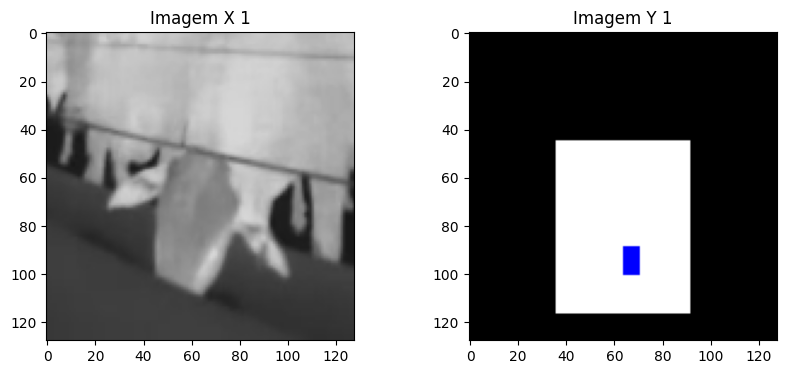

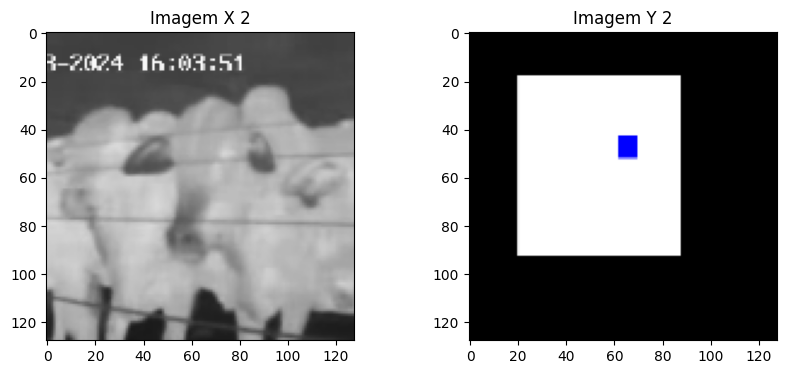

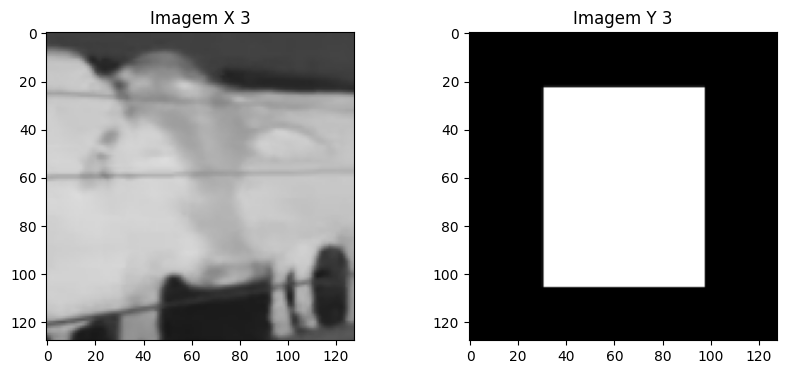

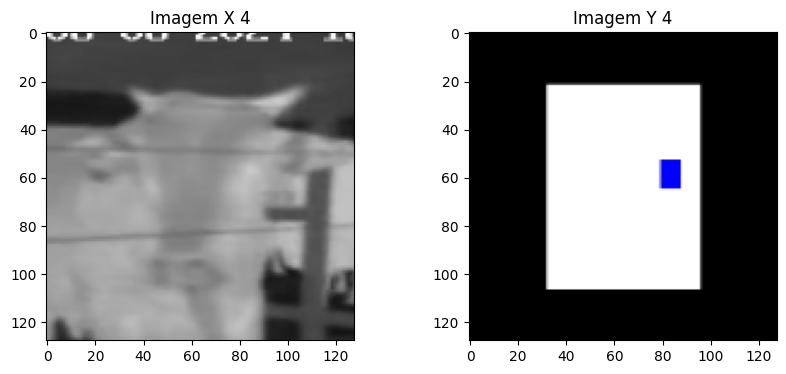

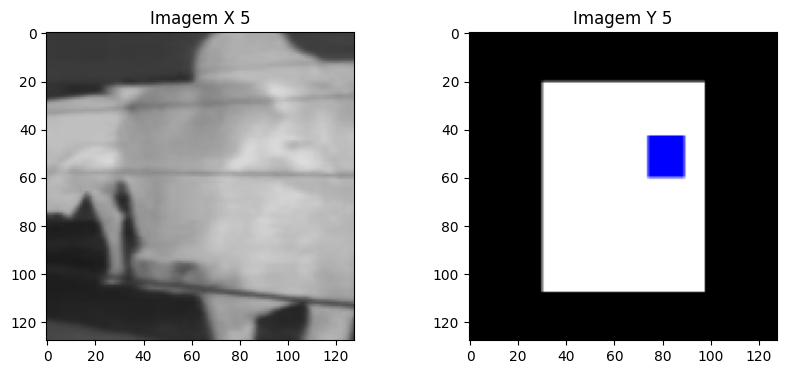

(2420, 128, 128, 3)


In [4]:
with h5py.File('/content/drive/MyDrive/data/combined_data.h5', 'r') as h5f:
    X_data = h5f['X'][:]
    Y_data = h5f['Y'][:]

for i in range(5):  # Mostrando as primeiras 5 imagens
    plt.figure(figsize=(10, 4))
    # Plotando a imagem X
    plt.subplot(1, 2, 1)
    plt.imshow(X_data[i])
    plt.title(f'Imagem X {i+1}')
    # Plotando a imagem Y
    plt.subplot(1, 2, 2)
    plt.imshow(Y_data[i])
    plt.title(f'Imagem Y {i+1}')
    plt.show()

# Normalizando os dados
X_data = X_data / 255.0
Y_data = Y_data / 255.0
print(Y_data.shape)

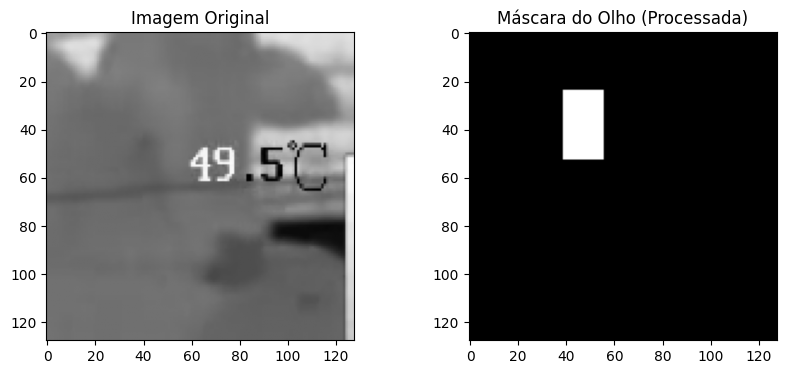

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Função para inspecionar os valores dos canais RGB na máscara
def inspect_mask_channels(mask):
    if mask.ndim == 3:  # Máscara RGB
        print("Valores do Canal Vermelho (R):", np.unique(mask[:, :, 0]))
        print("Valores do Canal Verde (G):", np.unique(mask[:, :, 1]))
        print("Valores do Canal Azul (B):", np.unique(mask[:, :, 2]))
    else:
        print("A máscara não possui 3 canais (RGB).")

# Função para criar uma máscara binária para o olho a partir de uma máscara RGB
def process_data(mask):
    """
    Função para criar uma máscara binária para o olho a partir de uma máscara RGB.
    Aqui, assumimos que o olho é azul e representado pelo valor 1.0 no canal azul.
    """
    if mask.ndim == 3:  # Garantir que estamos lidando com uma máscara RGB
        eye_mask = (mask[:, :, 2] == 1.0) & (mask[:, :, 0] == 0.0) & (mask[:, :, 1] == 0.0)  # Região azul (olho)
        eye_mask = eye_mask.astype(np.float32)  # Converte para float32 (necessário para TensorFlow)
    else:
        raise ValueError("A máscara fornecida não tem 3 canais (RGB). Verifique o formato da máscara.")

    return np.expand_dims(eye_mask, axis=-1)  # Expande a dimensão para (128, 128, 1)

# Aplicando o pré-processamento em todas as máscaras no conjunto de dados Y_data
Y_data_processed = np.array([process_data(mask) for mask in Y_data])

# Dividindo em treino e validação
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data_processed, test_size=0.2, random_state=42)

# Exibindo uma imagem de exemplo e sua respectiva máscara processada
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.title("Imagem Original")

plt.subplot(1, 2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.title("Máscara do Olho (Processada)")
plt.show()


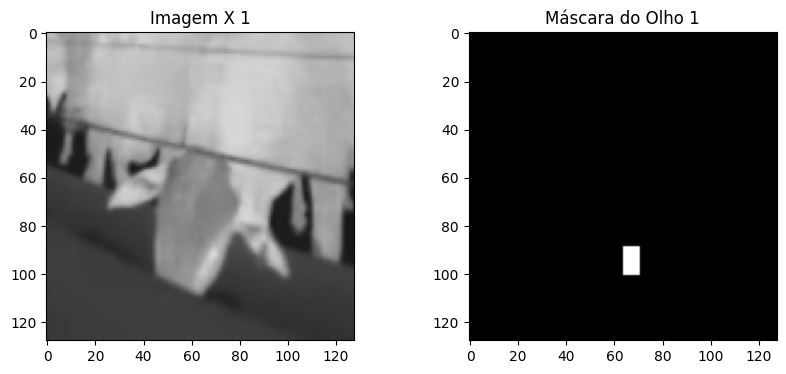

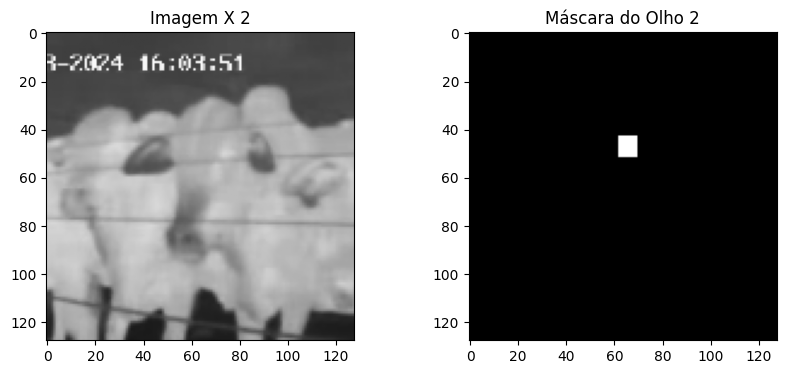

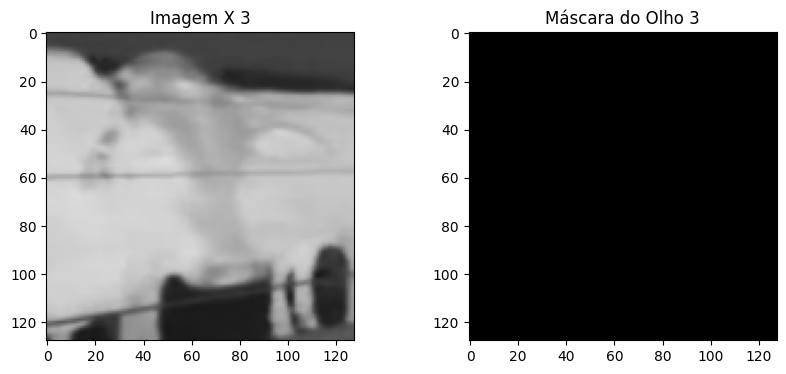

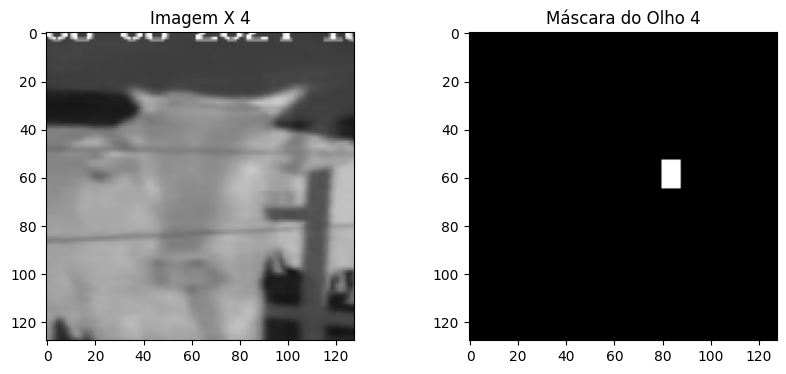

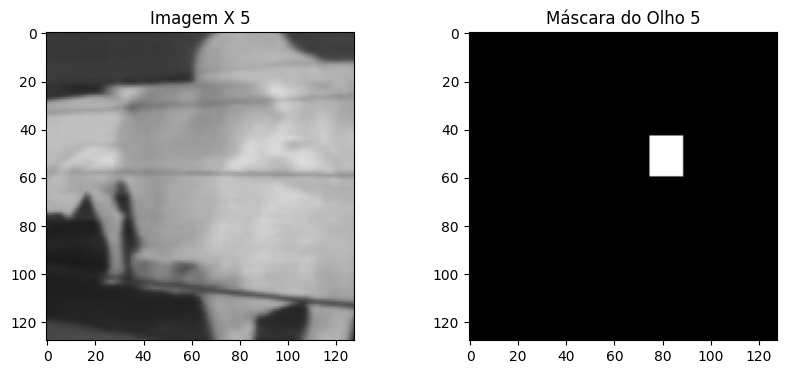

In [6]:
for i in range(5):  # Mostrando as primeiras 5 imagens
    plt.figure(figsize=(10, 4))

    # Plotando a imagem X
    plt.subplot(1, 2, 1)
    plt.imshow(X_data[i])
    plt.title(f'Imagem X {i+1}')

    # Plotando a máscara Y
    plt.subplot(1, 2, 2)
    plt.imshow(Y_data_processed[i], cmap='gray')
    plt.title(f'Máscara do Olho {i+1}')

    plt.show()

In [7]:
def conv_block(inputs,filterCount):
    x = Conv2D(filterCount,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filterCount,3,padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [8]:
def decoder_block(inputs,skip_features,filter_count):

    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filter_count)
    return x

In [15]:
def unet_vgg16(input_shape):
    inputs = Input(input_shape)
    vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=inputs)

    # Encoder
    skip1 = vgg16.get_layer("block1_conv2").output
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output

    # Centro
    center = vgg16.get_layer("block5_conv3").output

    # Decoder
    d1 = decoder_block(center,skip4,512)
    d2 = decoder_block(d1,skip3,256)
    d3 = decoder_block(d2,skip2,128)
    d4 = decoder_block(d3,skip1,64)

    # Saída com 1 canal (máscara binária)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [16]:
input_shape = (128,128,3)
model = unet_vgg16(input_shape)

In [17]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=["accuracy"])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
]

# Treinando o modelo
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=50,
                    callbacks=callbacks)

# Avaliação do modelo
model.evaluate(X_val, Y_val)

Epoch 1/50
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8847 - loss: 0.3466

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ━━━━━━━━━━━━━━━━━━━━ 54s 415ms/step - accuracy: 0.8860 - loss: 0.3441 - val_accuracy: 0.6195 - val_loss: 1.0855 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9881 - loss: 0.0771 - val_accuracy: 0.9859 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9880 - loss: 0.0552 - val_accuracy: 0.9869 - val_loss: 0.0697 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9887 - loss: 0.0447 - val_accuracy: 0.9885 - val_loss: 0.0699 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9891 - loss: 0.0405 - val_accuracy: 0.9885 - val_loss: 0.0690 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9894 - loss: 0.0364 - val_accuracy: 0.9885 - val_loss: 0.0603 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9897 - loss: 0.0342 - val_accuracy: 0.

[0.025897642597556114, 0.9911288619041443]

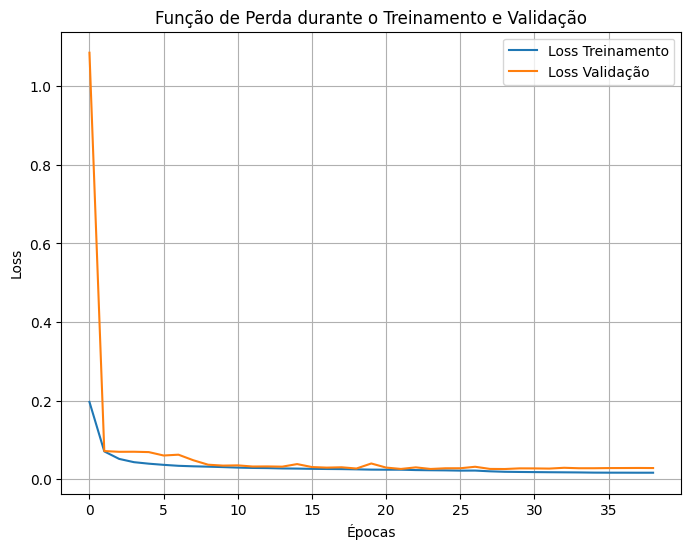

In [20]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico de perda (loss)
def plot_loss(history):
    plt.figure(figsize=(8, 6))

    # Plotando a perda no treinamento
    plt.plot(history.history['loss'], label='Loss Treinamento')

    # Plotando a perda na validação
    plt.plot(history.history['val_loss'], label='Loss Validação')

    # Configurações do gráfico
    plt.title('Função de Perda durante o Treinamento e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Mostrando o gráfico
    plt.show()

# Gerando o gráfico de perda
plot_loss(history)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


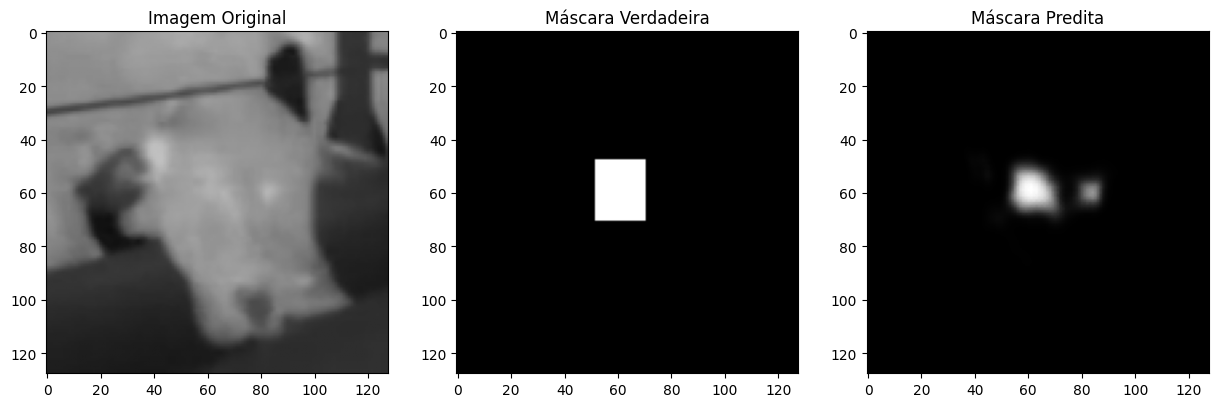

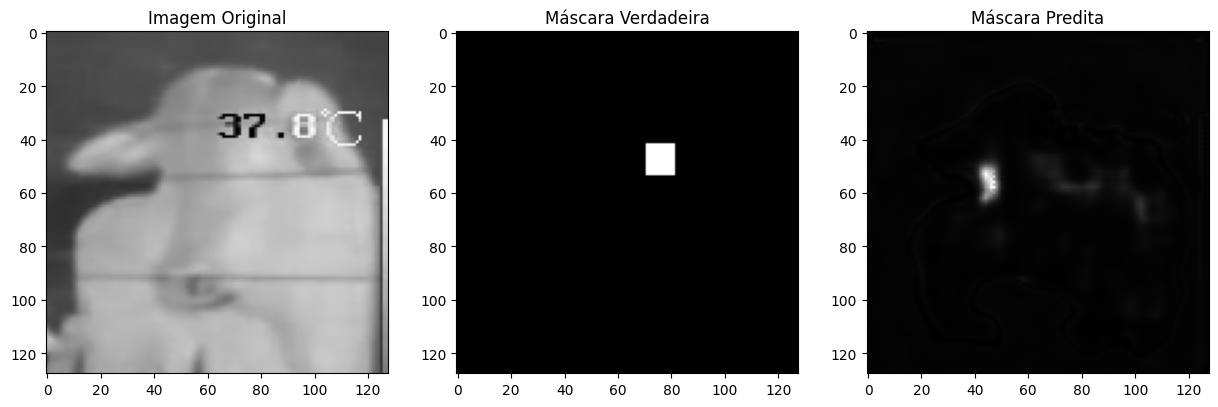

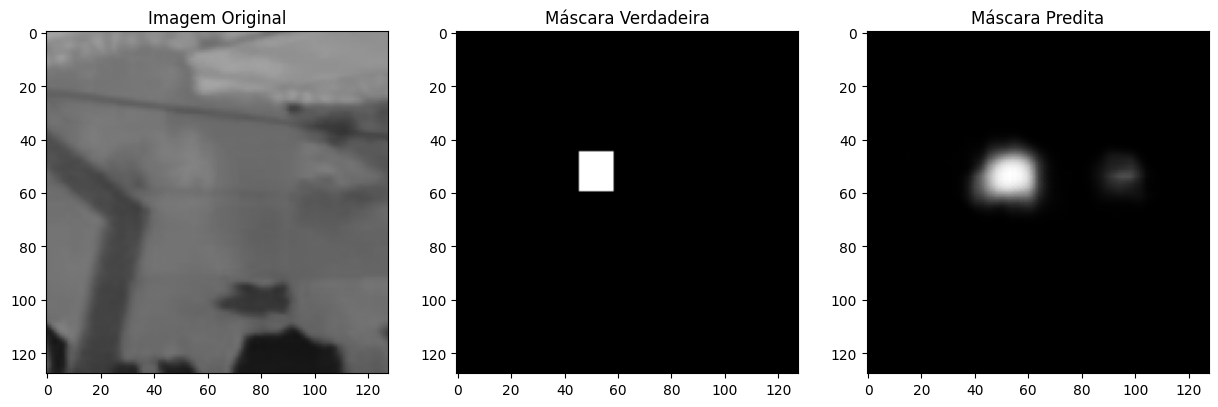

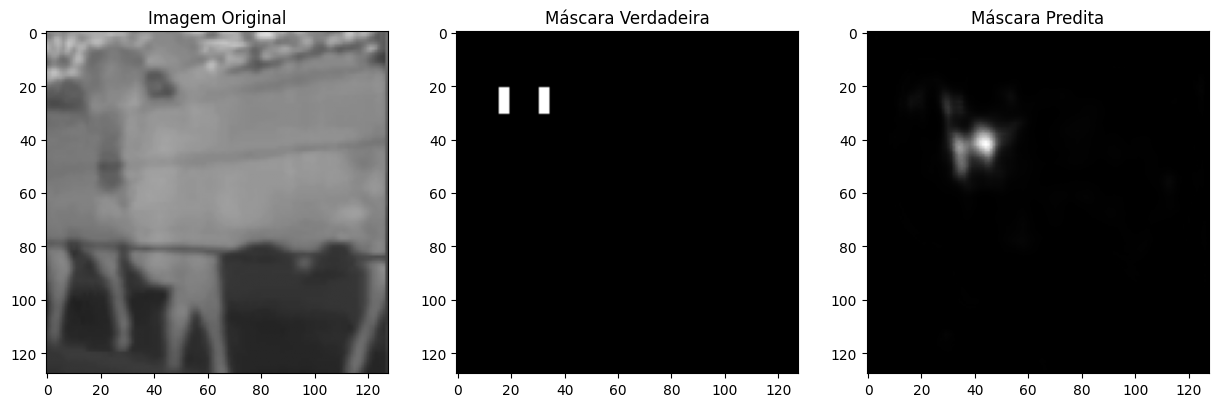

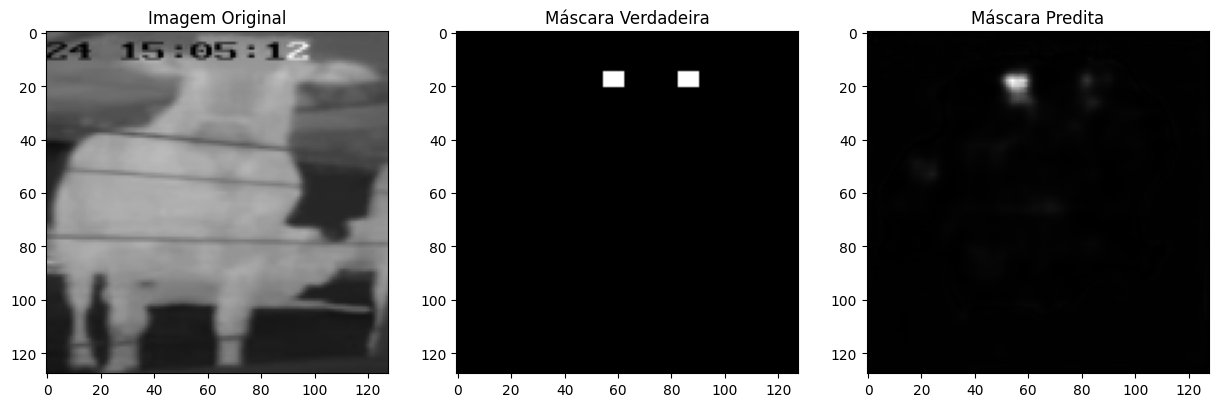

In [21]:
# Função para plotar imagem original, máscara real e previsão do modelo
def plot_results(X, Y_true, Y_pred, index):
    plt.figure(figsize=(15, 5))

    # Imagem original
    plt.subplot(1, 3, 1)
    plt.imshow(X[index])
    plt.title("Imagem Original")

    # Máscara verdadeira
    plt.subplot(1, 3, 2)
    plt.imshow(Y_true[index].squeeze(), cmap="gray")
    plt.title("Máscara Verdadeira")

    # Máscara predita
    plt.subplot(1, 3, 3)
    plt.imshow(Y_pred[index].squeeze(), cmap="gray")
    plt.title("Máscara Predita")

    plt.show()

# Fazer previsões no conjunto de validação
Y_pred = model.predict(X_val)

# Exibir resultados para algumas amostras
for i in range(5):
    plot_results(X_val, Y_val, Y_pred, i)